# Easy21 Playground

## Easy21 Environment

In [1]:
%matplotlib inline  

import gym
import gym_easy21
import numpy as np
from collections import defaultdict

### Random walk to test Easy21Env

In [2]:
env = gym.make("Easy21-v0")

episodes = 1
T = 1

for eps in range(episodes):
    obs = env.reset()
    print("Initial score ", obs)
    for t in range(T):
        action = env.action_space.sample()
        print("Choose " + ("stick" if action == 0 else "hit"))
        obs, reward, done, _ = env.step(action)
        print("Time step {}: ".format(t), obs, reward)
        if done:
            print("Episode {0} ends at time step {1}".format(eps, t))
            break

Initial score  (7, 3)
Choose stick
Time step 0:  (7, 19) -1
Episode 0 ends at time step 0


C:\Users\An\Anaconda3\envs\rl\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Solving Easy21 using Synchronous Dynamic Programming - Value Iteration (in progress, difficult because of large search tree)

In [ ]:
#def one_step_lookahead(V, Q, P, R, state_action, discount_factor=1.0):

# build value, action-value, state transition matrix for Easy21 MDP (terminal state defines as (0, 0))
P = defaultdict(defaultdict(float))
V = defaultdict(float)
Q = defaultdict(float)
R = defaultdict(float)
terminal = (0, 0)
for deal_score in range(1, 11):
    for player_score in range(1, 22):
        state = (player_score, deal_score)
        V[state] = 0
        Q[state] = np.zeros(2)
        for action in range(2):
            state_action = (state, action)
            Q[state][action] = 0
            
            # build transition matrix
            for i in range(1, 11):
                black_draw = player_score + i
                red_draw = player_score - i
                if black_draw > 21:
                    P[state_action][(terminal, action)] += 
            
            # build reward function
            
# table lookup MDP parameters (assuming defaultdict)
#    V - value function 
#    Q - action-value function
#    P - state transition matrix
#    R - intermediate rewards
#    discount factor
#    theta - early stopping condition
#    max_iteration - avoiding infinite loop 
def value_iteration(V, Q, P, R, discount_factor=1.0, theta=1e-8, max_iteration=1e6):
    for i in range(max_iteration):
        for state, action in Q:
            
        

### Utilities for plotting 

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_value_fn_and_policy(V, pi, num_episode, i):
    df = pd.DataFrame(V)
    fig = plt.figure(i, figsize=(20, 10))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_trisurf(df[1], df[0], df[2], cmap=plt.cm.viridis, linewidth=0.2)
    ax1.set(xlabel='Dealer score', ylabel='Player score', title="Value func MC control {} episodes".format(num_episode))
    
    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(pi, square=True, xticklabels=np.arange(1, 11), yticklabels=np.arange(1, 21), ax = ax2)
    ax2.invert_yaxis()
    ax2.set(xlabel='Dealer score', ylabel='Player score', title="Policy MC control {} episodes".format(num_episode))

## Every-visit Monte-Carlo Control with eps-greedy policy

### Implementation

In [4]:
# for plotting value func, we choose max value of action-value func (possible due to GLIE)
def get_value_and_deterministic_policy(Q, policy):
    V = []
    pi = np.zeros((21, 10))
    for state in Q:
        greedy_action = np.argmax(policy(state))
        V.append((state[0], state[1], Q[state][greedy_action]))
        pi[state[0] - 1][state[1] - 1] = greedy_action
    return V, pi

def eps_greedy_policy(Q, nA, N, N0=100):
    def policy(state):
        action_values = Q[state]
        greedy_action = np.argmax(action_values)
        eps = N0 / (N0 + N[state])
        action_prob = np.ones(nA) * eps / nA
        action_prob[greedy_action] += (1 - eps)
        return  action_prob
    return policy

def monte_carlo_control_on_policy(env, num_episode, discount_factor=1.0):
    nA = env.action_space.n # action set size of env
    
    N = defaultdict(int) # count number of visits of each state and state-action pair
    
    # initialize action-value func and e-greedy policy
    Q = defaultdict(lambda: np.zeros(nA))
    policy = eps_greedy_policy(Q, nA, N)
    
    for episode in range(1, num_episode + 1):
        state = env.reset()
        
        done = False
        eligibility_traces = defaultdict(float) # for tracking return of visited states
        returns = defaultdict(float) # return of each state-action pair
        
        while not done:
            action = np.random.choice(nA, p=policy(state))
            state_action = (state, action)
            
            # update routine of discount factor 
            for _state_action in eligibility_traces:
                eligibility_traces[_state_action] *= discount_factor
            
            # everytime we visit a state, increase one count
            eligibility_traces[state_action] += 1.0
            N[state_action] += 1
            N[state] += 1
            
            next_state, reward, done, _ = env.step(action)
            
            for _state_action in eligibility_traces:
                returns[_state_action] += eligibility_traces[_state_action] * reward
            
            state = next_state
        
        # update action-value func following GLIE schedule
        for state, action in returns:
            Q[state][action] += (1 / N[(state, action)]) * (returns[(state, action)] - Q[state][action])
        
        # improve policy
        policy = eps_greedy_policy(Q, nA, N)
    return Q, policy

### Evaluation

We will try MC-control with eps-greedy on 100000 and 500000 episodes to see how value function and policy function evolve.   

In [50]:
env = gym.make("Easy21-v0")

# try 100000 episodes
num_episode = 100000
Q1, policy1 = monte_carlo_control_on_policy(env, num_episode)
V1, pi1 = get_value_and_deterministic_policy(Q1, policy1)

# try 500000 episodes
num_episode = 500000
Q2, policy2 = monte_carlo_control_on_policy(env, num_episode)
V2, pi2 = get_value_and_deterministic_policy(Q2, policy2)

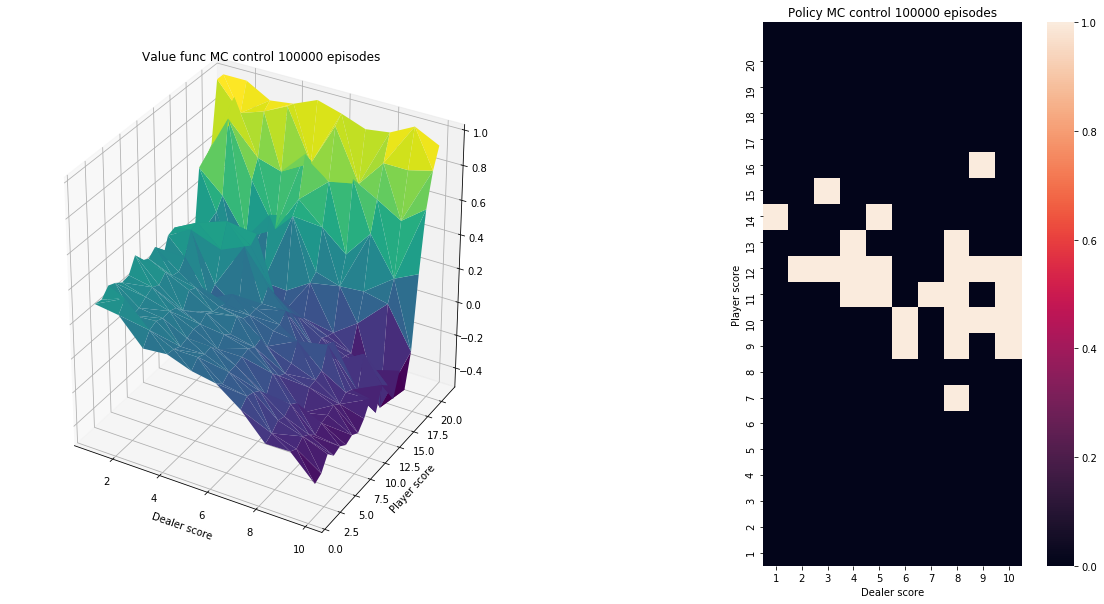

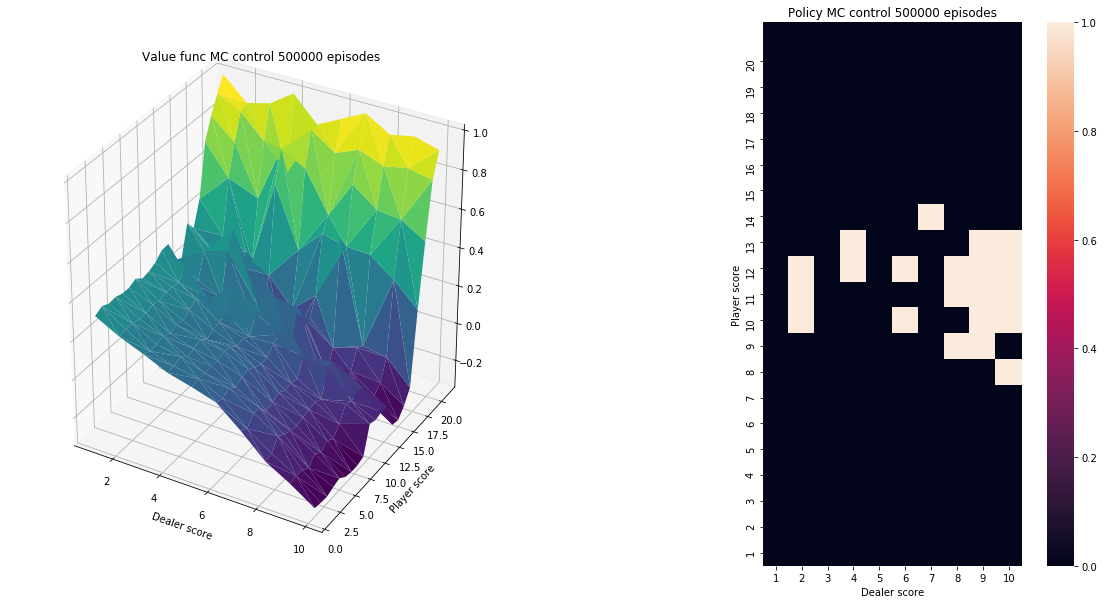

In [51]:
plot_value_fn_and_policy(V1, pi1, 100000, 1)
plot_value_fn_and_policy(V2, pi2, 500000, 2)
plt.show()

## Temporal-Difference Control (TD Sarsa(lambda)) 

### Implementation

In [52]:
def mean_square_error(Q, Q_optimal):
    error = 0
    for state in Q:
        error += np.square(Q[state] - Q_optimal[state]).sum()
    return error

def sarsa_lambda_control_on_policy(env, num_episode, discount_factor=1.0, Lambda=0.0, error_data=[], Q_optimal=None, print_error=False):
    nA = env.action_space.n # action set size of env
    
    N = defaultdict(int) # count number of visits of each state and state-action pair
    
    # initialize action-value func and e-greedy policy
    Q = defaultdict(lambda: np.zeros(nA))
    policy = eps_greedy_policy(Q, nA, N)
    
    for episode in range(1, num_episode + 1):
        state = env.reset()
        action = np.random.choice(nA, p=policy(state))
        
        done = False
        eligibility_traces = defaultdict(float) # for tracking return of visited states
        
        while not done:         
            state_action = (state, action)
            
            # update routine of discount factor 
            for _state_action in eligibility_traces:
                eligibility_traces[_state_action] *= discount_factor * Lambda
            
            # everytime we visit a state, increase one count
            eligibility_traces[state_action] += 1.0
            N[state_action] += 1
            N[state] += 1
            
            next_state, reward, done, _ = env.step(action)
            next_action = -1 # undefine action
            
            td_error = 0
            if done: # just to avoid adding "burst" state to Q e.g (-inf, 10)
                td_error = reward -  Q[state][action]
            else:
                next_action = np.random.choice(nA, p=policy(next_state))
                td_error = reward + discount_factor * Q[next_state][next_action] - Q[state][action]
                
            
            #update action-value
            Q[state][action] += (1 / N[(state, action)]) * td_error * eligibility_traces[state_action]
            
            state = next_state
            action = next_action
    
        # improve policy
        policy = eps_greedy_policy(Q, nA, N)
        
        # report mean square error between Q and Q optimal
        if Q_optimal != None and episode % 1000 == 0:
            error = mean_square_error(Q, Q_optimal)
            error_data.append([episode, error])
            if print_error:
                print("Episode {} Mean squared error: ".format(episode), error)
            
            
    return Q, policy

### Evaluation

In [53]:
env = gym.make("Easy21-v0")

# assuming already run monte-carlo to find optimal Q
Q_optimal = Q2

# try 500000 episodes on lambda = 0.0
num_episode = 500000
error_data3 = []
Q3, policy3 = sarsa_lambda_control_on_policy(env, num_episode, error_data=error_data3, Q_optimal = Q_optimal)
V3, pi3 = get_value_and_deterministic_policy(Q3, policy3)

# try 500000 episodes on lambda = 0.0
num_episode = 500000
error_data4 = []
Q4, policy4 = sarsa_lambda_control_on_policy(env, num_episode, Lambda=1.0, error_data=error_data4, Q_optimal = Q_optimal)
V4, pi4 = get_value_and_deterministic_policy(Q4, policy4)

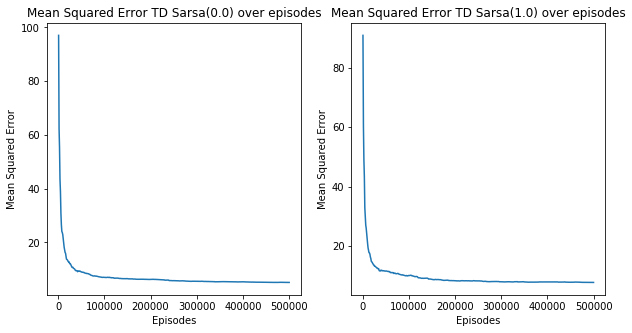

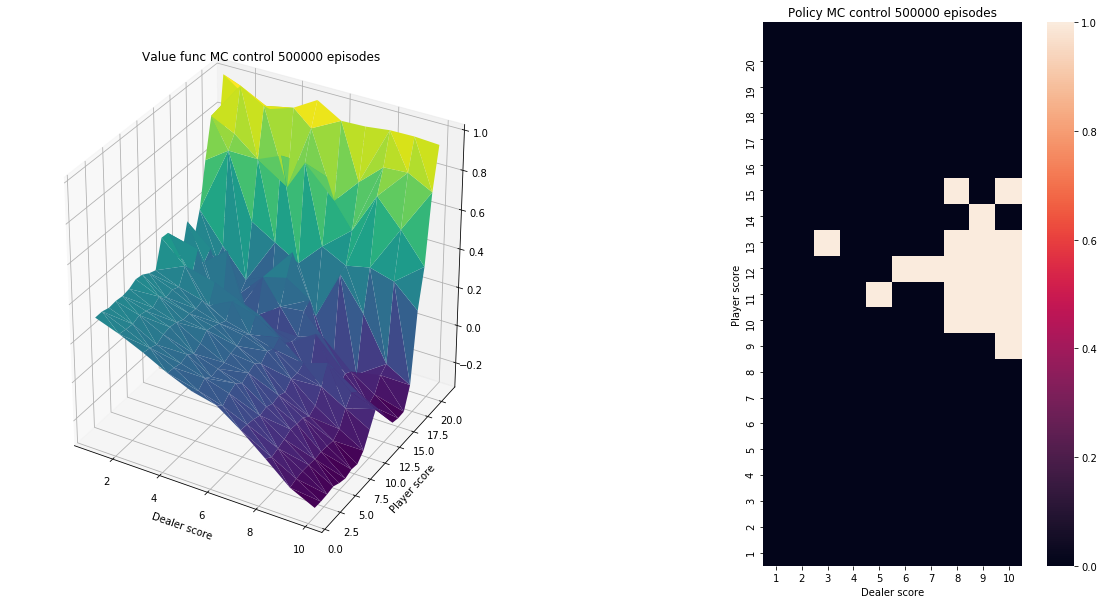

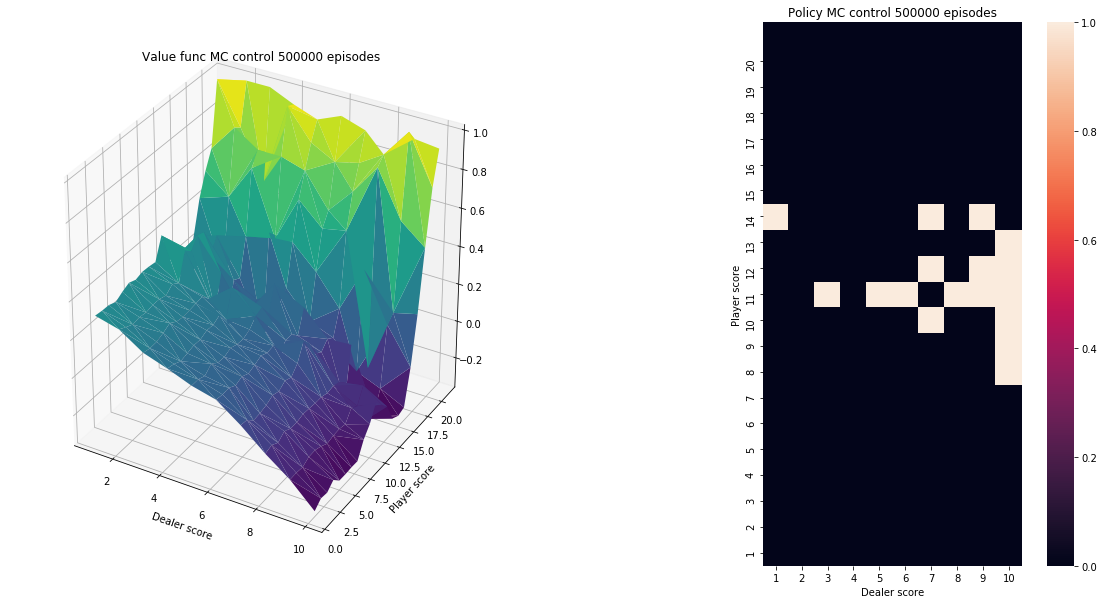

In [56]:
x1, y1 = zip(*error_data3)
x2, y2 = zip(*error_data4)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x = x1, y = y1, ax=ax1)
ax1.set(title="Mean Squared Error TD Sarsa(0.0) over episodes", xlabel="Episodes", ylabel="Mean Squared Error")

ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x = x2, y = y2, ax=ax2)
ax2.set(title="Mean Squared Error TD Sarsa(1.0) over episodes", xlabel="Episodes", ylabel="Mean Squared Error")

plot_value_fn_and_policy(V3, pi3, 500000, 2)
plot_value_fn_and_policy(V4, pi4, 500000, 3)

plt.show()

## TD Sarsa(lambda) with Linear Approximation function 

### Implementation

In [57]:
dealer_ranges = [range(1, 5), range(4, 8), range(7, 11)]
player_ranges = [range(1, 7), range(4, 10), range(7, 13), range(10, 16), range(13, 19), range(16, 22)]

def state_action_to_feature_map(state_action): # to fullfill feature requirement of exercise 4
    feature = np.zeros((3, 6, 2))
    x = [(state_action[0][1] in r) for r in dealer_ranges]
    x_indices = [i for i, val in enumerate(x) if val == True]
    y = [(state_action[0][0] in r) for r in player_ranges]
    y_indices = [i for i, val in enumerate(y) if val == True]
    
    for i in x_indices:
        for j in y_indices:
            feature[i][j][state_action[1]] = 1
    return feature

def action_linear_approximation_fn(theta):
    def Q(state_action):
        feature = state_action_to_feature_map(state_action)
        return (feature * theta).sum()
    return Q       

def constant_eps_greedy_policy(theta, nA, eps):
    def policy(state):
        Q = action_linear_approximation_fn(theta)
        greedy_action = np.argmax([Q((state, action)) for action in range(nA)])
        action_prob = np.ones(nA) * eps / nA
        action_prob[greedy_action] += (1 - eps)
        return  action_prob
    return policy

def mean_square_error_linear_approximation(Q, Q_optimal):
    error = 0
    for state in Q_optimal:
        for action in range(2):
            error += np.square(Q_optimal[state][action] - Q((state, action)))
    return error

def sarsa_lambda_control_on_policy_with_linear_approximation(env, num_episode, discount_factor=1.0, Lambda=0.0, eps=0.05, step_size=0.01, error_data=[], Q_optimal=None, print_error=False):
    nA = env.action_space.n # action set size of env
    
    # initialize action-value func parameters and e-greedy policy
    theta = np.zeros((3, 6, 2))
    policy = constant_eps_greedy_policy(theta, nA, eps)
    
    for episode in range(1, num_episode + 1):
        state = env.reset()
        action = np.random.choice(nA, p=policy(state))
        
        done = False
        eligibility_traces = np.zeros((3, 6, 2)) 
        
        while not done:         
            state_action = (state, action)
            
            # update routine of discount factor 
            eligibility_traces *= discount_factor * Lambda
            
            # everytime we visit a state corresponding a feature, increase one count
            eligibility_traces += state_action_to_feature_map(state_action)
            
            next_state, reward, done, _ = env.step(action)
            next_action = -1
            
            
            # get approximated Q and feature from state_action
            Q = action_linear_approximation_fn(theta)        
            td_error = 0
            if done:
                td_error = reward - Q(state_action)
            else:
                next_action = np.random.choice(nA, p=policy(next_state))
                td_error = reward + discount_factor * Q((next_state, next_action)) - Q(state_action)
            
            
            #update action-value parameter
            theta += step_size * td_error * eligibility_traces
            
            state = next_state
            action = next_action
    
        # improve policy
        policy = constant_eps_greedy_policy(theta, nA, eps)
        
        # report mean square error between Q and Q optimal
        if Q_optimal != None and episode % 1000 == 0:
            Q = action_linear_approximation_fn(theta)
            error = mean_square_error_linear_approximation(Q, Q_optimal)
            error_data.append([episode, error])
            if print_error:
                print("Episode {} Mean squared error: ".format(episode), error)
            
            
    return theta, policy
    

### Evaluation

In [58]:
env = gym.make("Easy21-v0")

# assuming already run monte-carlo to find optimal Q
Q_optimal = Q2

# try 500000 episodes on lambda = 0.0
num_episode = 500000
error_data5 = []
theta, policy = sarsa_lambda_control_on_policy_with_linear_approximation(env, num_episode, error_data=error_data5, Q_optimal = Q_optimal)

# try 500000 episodes on lambda = 1.0
num_episode = 500000
error_data6 = []
theta, policy = sarsa_lambda_control_on_policy_with_linear_approximation(env, num_episode, Lambda=1.0, error_data=error_data6, Q_optimal = Q_optimal)

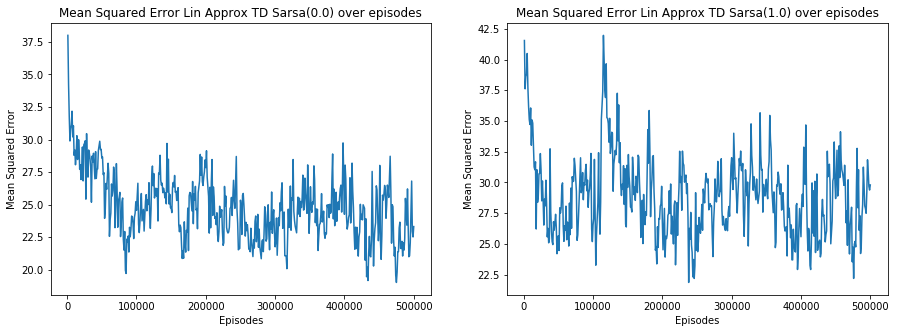

In [60]:
x3, y3 = zip(*error_data5)
x4, y4 = zip(*error_data6)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x = x3, y = y3, ax=ax1)
ax1.set(title="Mean Squared Error Lin Approx TD Sarsa(0.0) over episodes", xlabel="Episodes", ylabel="Mean Squared Error")

ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x = x4, y = y4, ax=ax2)
ax2.set(title="Mean Squared Error Lin Approx TD Sarsa(1.0) over episodes", xlabel="Episodes", ylabel="Mean Squared Error")

plt.show()

Downsampling linear approximation like the exercise 4 is not good as expected. The causes will be discussed soon.